## Imports

In [1]:
import requests
import xyzservices.providers as xyz
from shapely import box

from utils import *

## US states & counties
Download the 2020 boundary shapefiles of the lower 48 US states and counties using the [TIGER/Line API](https://www.census.gov/data/developers/data-sets/TIGERweb-map-service.html).

**State boundaries**:

In [2]:
url = 'https://www2.census.gov/geo/tiger/TIGER2020/STATE/tl_2020_us_state.zip'
states = (gpd.read_file(url).rename(columns=str.lower).to_crs(CRS_DEG)
          [['geoid', 'name', 'region', 'division', 'geometry']])
url = 'https://raw.githubusercontent.com/jasonong/List-of-US-States/refs/heads/master/states.csv'
state_abbr = pd.read_csv(url).rename(columns=D(State='name', Abbreviation='code'))
states = states.merge(state_abbr, on='name')
# rename US Census regions and divisions
states.region = states.region.astype(int).map({
    1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'})
states.division = states.division.astype(int).map({
    1: '1. New England', 2: '2. Middle Atlantic',
    3: '3. East North Central', 4: '4. West North Central',
    5: '5. South Atlantic', 6: '6. East South Central',
    7: '7. West South Central', 8: '8. Mountain', 9: '9. Pacific'
})
# remove Alaska and Hawaii
states = (states[~states.name.isin(['Alaska', 'Hawaii'])]
          .sort_values('geoid').reset_index(drop=True)
          ['geoid code name region division geometry'.split()])
states.to_parquet(mkdir('data/geometry') / 'states.parquet') # 2s
disp(states := gpd.read_parquet('data/geometry/states.parquet'));

49 rows x 6 cols; Memory: 0.0 MiB; <Geographic 2D CRS: EPSG:4326>


,geoid,code,name,region,division,geometry
,<object>,<object>,<object>,<object>,<object>,<geometry>
0,01,AL,Alabama,South,6. East South Central,"POLYGON ((-88.139988 34.581703, -88.139969 34...."


**County boundaries**:

In [3]:
url = 'https://www2.census.gov/geo/tiger/TIGER2020/COUNTY/tl_2020_us_county.zip'
counties = (gpd.read_file(url).rename(columns=str.lower)
            .rename(columns=D(name='county')).to_crs(CRS_DEG)
            ['geoid county aland awater geometry'.split()])
for x in ['aland', 'awater']: # convert area from sq.m. to sq.mi.
    counties[x] = (counties[x] * SQM2SQMI).astype(F32)
counties.to_parquet('data/geometry/counties.parquet') # 7s
disp(counties := gpd.read_parquet('data/geometry/counties.parquet'));

3,234 rows x 5 cols; Memory: 0.4 MiB; <Geographic 2D CRS: EPSG:4326>


,geoid,county,aland,awater,geometry
,<object>,<object>,<float32>,<float32>,<geometry>
0,31039,Cuming,570.519409,4.127492,"POLYGON ((-97.019516 42.004097, -97.019519 42...."


## Population
Download the population and labor force size of each census block group from the American Community Survey dataset and additionally aggregate to the tract and county levels.

In [4]:
popu_cols = D(B01001_001E='popu', B23025_002E='labor')
popu = []
for state in tqdm(states.geoid): # for each state
    url = ('https://api.census.gov/data/2020/acs/acs5?' +
           'get=' + ','.join(popu_cols) + '&for=block+group:*' +
           f'&in=state:{state}+county:*+tract:*')
    data = requests.get(url).json()
    df = Pdf(data[1:], columns=data[0])
    df.insert(0, 'geoid', df.pop('state') + df.pop('county') + 
              df.pop('tract') + df.pop('block group'))
    df = df.rename(columns=popu_cols).astype(D(popu=I32, labor=I32))
    popu.append(df.assign(level='BG'))
    for level, nchar in [('Tract', 11), ('County', 5)]:
        df2 = df.assign(geoid=df.geoid.str[:nchar])
        df2 = df2.groupby('geoid')[['popu', 'labor']].sum()
        popu.append(df2.reset_index().assign(level=level))
popu = (pd.concat(popu).reset_index(drop=True).astype(D(level=CAT))
        [['geoid', 'level', 'popu', 'labor']])
popu.to_parquet('data/geometry/population.parquet') # 1m38s
disp(popu := pd.read_parquet('data/geometry/population.parquet'));

325,077 rows x 4 cols; Memory: 21.6 MiB


,geoid,level,popu,labor
,<object>,<category>,<int32>,<int32>
0,010610503006,BG,758,297


## Urban areas
Download the constituent census blocks of urban areas as defined by the Census Bureau. Then, identify the corresponding block groups and tracts which contain at least one block in each urban area.

In [5]:
url = 'https://www2.census.gov/geo/docs/reference/ua/2020_UA_BLOCKS.txt'
cols = {'GEOID': 'geoid', '2020_UA_NAME': 'name', '2020_UACE': 'code'}
df = pd.read_csv(url, sep='|', encoding_errors='replace', usecols=list(cols))
df.rename(columns=cols, inplace=True)
df.code = df.code.astype(str).str.zfill(5)
df.geoid = df.geoid.astype(str).str.zfill(15)
urba = []
for level, nchar in [('County', 5), ('Tract', 11), ('BG', 12)]:
    df2 = df.assign(geoid=df.geoid.str[:nchar])
    df2 = df2.groupby(['code', 'name', 'geoid']).size()
    df2 = df2.rename('n').reset_index().sort_values('n', ascending=0)
    df2 = df2.drop_duplicates('geoid').sort_values('geoid')
    urba.append(df2.assign(level=level))
urba = pd.concat(urba).reset_index(drop=True)
urba = urba[['code', 'name', 'level', 'geoid']].astype(
    {x: CAT for x in ['level', 'name', 'code']}).disp()
urba.to_parquet('data/geometry/urban_zones.parquet') # 18s
disp(urba := pd.read_parquet('data/geometry/urban_zones.parquet'));

275,549 rows x 4 cols; Memory: 17.7 MiB


,code,name,level,geoid
,<category>,<category>,<category>,<object>
0,58600,"Montgomery, AL",County,01001


## 50 largest cities
Select the 50 most populous urban areas using the tract-level population.

In [6]:
def get_largest_cities(top, urba=urba, popu=popu):
    urba = urba.rename(columns=D(name='urba', code='ua_code'))
    df = urba.merge(popu[['geoid', 'popu']])
    df = df.groupby('urba', observed=False)['popu'].sum()
    df = df.sort_values(ascending=0).head(top).reset_index()
    df['city'] = [x.split(',')[0].split('-')[0].split('/')[0] for x in df.urba]
    print(Arr(df.city))
    df = urba[['geoid', 'level', 'ua_code', 'urba']].merge(df[['urba', 'city']])
    df = df.astype(D(level=str, urba=str, city=str))
    return df

disp(top50 := get_largest_cities(50));

['New York' 'Los Angeles' 'Chicago' 'Miami' 'Houston' 'Philadelphia'
 'Dallas' 'Washington' 'Atlanta' 'Boston' 'Phoenix' 'Detroit' 'Seattle'
 'San Francisco' 'San Diego' 'Riverside' 'Minneapolis' 'Tampa' 'Denver'
 'St. Louis' 'Baltimore' 'Portland' 'Las Vegas' 'San Antonio' 'Sacramento'
 'Austin' 'Pittsburgh' 'San Jose' 'Orlando' 'Cincinnati' 'Kansas City'
 'Indianapolis' 'Cleveland' 'Columbus' 'Virginia Beach' 'Charlotte'
 'Providence' 'Milwaukee' 'Jacksonville' 'Nashville' 'Salt Lake City'
 'Raleigh' 'Richmond' 'Memphis' 'Hartford' 'Buffalo' 'Louisville'
 'Oklahoma City' 'Tucson' 'Bridgeport']
144,156 rows x 5 cols; Memory: 33.8 MiB


,geoid,level,ua_code,urba,city
,<object>,<object>,<category>,<object>,<object>
0,04013,County,69184,"Phoenix--Mesa--Scottsdale, AZ",Phoenix


## Zones
Download the shapefile of the block groups and tracts which lie in the largest urban areas. Remove the zones with no land area for better plotting.

In [7]:
uri = 'https://www2.census.gov/geo/tiger/TIGER2020'
cols = 'geoid level county ua_code city aland awater popu labor geometry'.split()
zones = (counties.merge(top50, on='geoid')
         .merge(popu.drop(columns='level'), on='geoid')[cols])
# for each state which includes at least one major urban area
for state in tqdm(set(top50.geoid.str[:2])):
    for level in ['bg', 'tract']:
        df = gpd.read_file('{}/{}/tl_2020_{}_{}.zip'.format(
            uri, level.upper(), state, level))
        df = df[df.ALAND > 0] # remove water-only zones
        df = df.to_crs(CRS_DEG).rename(columns=str.lower)
        for x in ['aland', 'awater']: # convert area from sq.m. to sq.mi.
            df[x] = (df[x] * SQM2SQMI).astype(F32)
        df = df.merge(top50, on='geoid')
        df = df.merge(popu.drop(columns='level'), on='geoid')
        df['county_id'] = df.geoid.str[:5]
        df = df.merge(counties.rename(columns=D(geoid='county_id'))
                      [['county_id', 'county']], on='county_id')
        zones = pd.concat([zones, df[cols]], ignore_index=True)
zones = zones.reset_index(drop=True).astype(D(
    level=CAT, county=CAT, ua_code=CAT, city=CAT)).disp()
zones.to_parquet('data/geometry/zones.parquet') # 5m37s
disp(zones := gpd.read_parquet('data/geometry/zones.parquet'));

143,971 rows x 10 cols; Memory: 12.7 MiB; <Geographic 2D CRS: EPSG:4326>


,geoid,level,county,ua_code,city,aland,awater,popu,labor,geometry
,<object>,<category>,<category>,<category>,<category>,<float32>,<float32>,<int32>,<int32>,<geometry>
0,42007,County,Beaver,69697,Pittsburgh,434.692993,9.329071,164781,84153,"POLYGON ((-80.518963 40.733741, -80.518965 40...."


## Zone centroids
Coordinates of zone centroids to be used by the OSRM routing engine in `get_ttm.py` (via `osrm.sh`).

In [8]:
pts = (zones.set_index(['geoid', 'level', 'city']).to_crs(CRS_M)
       .centroid.to_crs(CRS_DEG).get_coordinates().reset_index()
       .astype(D(level=str, city=str, x=F32, y=F32)))
pts.city = [x.lower().replace(' ', '-').replace('.', '') for x in pts.city]
pts.level = pts.level.str.lower()
pts.to_parquet('data/geometry/centroids.parquet') # 4s
disp(pts := pd.read_parquet('data/geometry/centroids.parquet'));

143,971 rows x 5 cols; Memory: 24.4 MiB


,geoid,level,city,x,y
,<object>,<object>,<object>,<float32>,<float32>
0,42007,county,pittsburgh,-80.349266,40.682495


## City to region
Associate each city with a US Census region and find its bounding box using its block group (BG) geometry. This is to be used by `extract_osm.sh` to prepare the OSM extracts of the urban areas using the extracts of the US Census regions. For cities spanning multiple regions, select the region with the most BGs.

In [9]:
bounds = (zones.set_index('city').bounds
          .groupby('city', observed=True).agg(D(
              minx='min', miny='min', maxx='max', maxy='max'))
          .apply(lambda x: np.round(x, 6)))
city2rgn = (filt(zones, level='BG')
            .assign(geoid=lambda df: df.geoid.str[:2])
            .groupby(['geoid', 'city'], observed=True)
            .size().rename('nBG').sort_values(ascending=0)
            .reset_index().drop_duplicates(subset='city')
            .merge(states, on='geoid')[['city', 'region']]
            .merge(bounds, on='city'))
for col in ['city', 'region']:
    city2rgn[col] = [x.lower().replace(' ', '-').replace('.', '')
                     for x in city2rgn[col]]
city2rgn.to_csv(mkdir('data/export') / 'city_region.csv', index=False)
city2rgn

,city,region,minx,miny,maxx,maxy
0,new-york,northeast,-74.982642,39.475198,-71.777491,41.527194
1,los-angeles,west,-118.951721,32.750040,-117.412987,34.823302
2,chicago,midwest,-88.707421,41.162186,-86.929353,42.495637
3,miami,south,-80.886053,25.137420,-79.974306,27.044106
4,houston,south,-96.088912,28.764837,-94.353383,30.271502
5,dallas,south,-97.770719,32.052087,-96.295057,33.405504
6,atlanta,south,-85.050310,33.191043,-83.674644,34.412590
7,boston,northeast,-71.898773,41.565851,-70.322522,42.967195
8,detroit,midwest,-83.701940,41.988330,-82.509937,42.972714
9,philadelphia,northeast,-76.233279,39.290281,-74.389708,40.608580


# Visualize

## Fig: Spatial levels

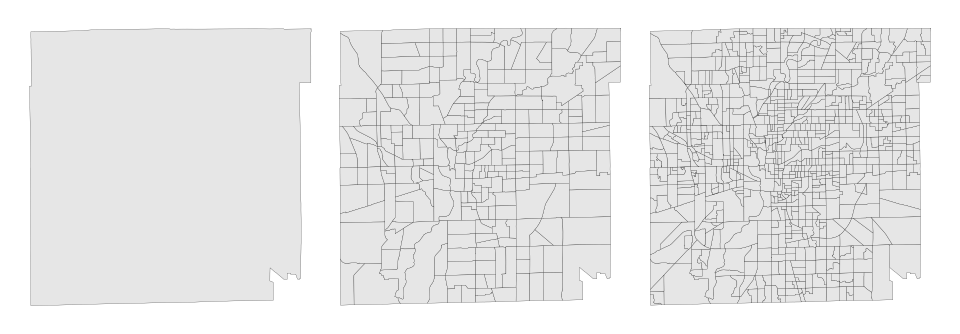

In [10]:
bgs = filt(zones, city='Indianapolis', county='Marion', level='BG')
tracts = bgs.assign(geoid=bgs.geoid.str[:11]).dissolve('geoid').reset_index()
counties = tracts.assign(geoid=tracts.geoid.str[:5]).dissolve('geoid')
_, axes = plt.subplots(1, 3, figsize=(8, 3), dpi=150)
for i, df in enumerate([counties, tracts, bgs]):
    df.plot(ax=plot(axes[i], axoff=1), fc='.9', ec='k', lw=0.1)
plt.subplots_adjust(wspace=0)

## Fig: Map of each city
Plot the map of each metropolitan area, ensuring a square fit to each city's figure.

In [10]:
city_limits = filt(zones, level='BG').dissolve('city').reset_index().to_crs(CRS_M)
disp(city_limits); # 37s

50 rows x 9 cols; Memory: 0.2 MiB; <Projected CRS: EPSG:3857>


,city,geometry,geoid,county,ua_code,aland,awater,popu,labor
,<category>,<geometry>,<object>,<category>,<category>,<float32>,<float32>,<int32>,<int32>
0,Atlanta,"POLYGON ((-9440657.250213 3926719.254374, -944...",131210101212,Fulton,03817,0.067793,0.0,20,10


In [11]:
disp(counties := filt(zones, level='County').to_crs(CRS_M), 0);

226 rows x 9 cols; Memory: 0.2 MiB; <Projected CRS: EPSG:3857>


,geoid,county,ua_code,city,aland,awater,popu,labor,geometry
,<object>,<category>,<category>,<category>,<float32>,<float32>,<int32>,<int32>,<geometry>


In [13]:
# total 4m39s
city_ranks = (filt(zones, level='BG').groupby('city', observed=True)
              .popu.sum().sort_values(ascending=0).reset_index()
              .assign(rank=lambda df: df.index + 1)
              .set_index('city')['rank'])
for batch, cities in enumerate(np.split(city_ranks.index, 2)):
    fig, axes = plt.subplots(5, 5, figsize=(30, 30), dpi=100)
    for rank, city in enumerate(cities):
        cnty = filt(zones, city=city, level='County').to_crs(CRS_M)
        boundary = filt(city_limits, city=city)
        minx, miny, maxx, maxy = boundary.bounds.iloc[0]
        cx, cy = (maxx + minx) / 2, (maxy + miny) / 2
        width, height = maxx - minx, maxy - miny
        d = max(width, height) / 2 # half-width of the desired square
        bbox = x0, y0, x1, y1 = cx - d, cy - d, cx + d, cy + d
        bbox = Gdf(geometry=[box(*bbox)], crs=CRS_M)
        ax = axes.flatten()[rank]
        ax.set_title(f'{city_ranks.loc[city]}. {city}',
                     fontsize=20, fontweight='bold')
        boundary.plot(ax=ax, color='tomato', ec='none', alpha=0.4)
        cnty.plot(ax=ax, fc='none', ec='k')
        for _, r in cnty.iterrows():
            x, y = r.geometry.centroid.coords[0]
            if x < x0 or x > x1 or y < y0 or y > y1:
                continue
            ax.text(x, y, r.county, fontsize=10, ha='center', va='center')
        bbox.plot(ax=ax, alpha=0)
        basemap(ax, crs=CRS_M)
        ax.set_xlim(x0, x1)
        ax.set_ylim(y0, y1)
    plt.subplots_adjust(wspace=0.05, hspace=0.1)
    imsave(f'City boundaries {batch + 1}', fig=fig)
    plt.close()